In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [4]:
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((48, 48), antialias=True),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

In [7]:
trainset=ImageFolder(root="/content/drive/MyDrive/Datasetss/Training", transform=transform)
testset=ImageFolder(root="/content/drive/MyDrive/Datasetss/Testing", transform=transform)
valset=ImageFolder(root="/content/drive/MyDrive/Datasetss/Validation", transform=transform)

In [8]:
train_iterator = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valid_iterator = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [23]:
import torch.nn as nn
import torch.nn.functional as F

num_classes = 4

class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=258, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=258, out_channels=126, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer3 = nn.Conv2d(in_channels=126, out_channels=100, kernel_size=3)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(100 * 4 * 4, 1026)  # Adjusted input size
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1026, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.max_pool1(out)
        out = self.conv_layer2(out)
        out = self.max_pool2(out)
        out = self.conv_layer3(out)
        out = self.max_pool3(out)

        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out

model = ConvNeuralNet(num_classes)


In [24]:
model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()
learning_rate=0.001
# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

total_step = len(train_iterator)
#num_epoch=100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [25]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [26]:
import tqdm
import numpy as np
train_acc=[]
train_loss=[]
test_loss=[]
test_acc=[]
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    #train_acc=[]
    model.train()

    for i, (x,y) in enumerate(train_iterator):

        x = x.to(device)
        y = y.to(device)
        #print("loading optimizer for training")
        optimizer.zero_grad()

        y_pred= model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #a=int(epoch_acc)*100
        #a="%.2f" % a

        #train_loss(100-int(a))


    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    #test_acc=[]
    model.eval()

    with torch.no_grad():

        for i, (x,y) in enumerate(valid_iterator):

            x = x.to(device)
            y = y.to(device)
            #print("loadinl for evaluation mode")
            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)


            epoch_loss += loss.item()
            epoch_acc += acc.item()
            #b=int(epoch_acc)*100
            #b="%.2f" % b

            #test_loss(100-b)

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
import numpy as np
import time
from tqdm import trange

EPOCHS = 100
best_valid_loss = float('inf')
train_result = []
test_result = []

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    train_result.append(train_acc)
    test_result.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')


Epochs:   1%|          | 1/100 [06:32<10:47:29, 392.42s/it]

Epoch: 01 | Epoch Time: 6m 32s
	Train Loss: 1.364 | Train Acc: 44.74%
	Val. Loss: 1.341 | Val. Acc: 42.27%


Epochs:   2%|▏         | 2/100 [06:52<4:43:22, 173.50s/it] 

Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 1.278 | Train Acc: 51.25%
	Val. Loss: 1.214 | Val. Acc: 45.38%


Epochs:   3%|▎         | 3/100 [07:11<2:46:23, 102.92s/it]

Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 1.087 | Train Acc: 55.61%
	Val. Loss: 0.998 | Val. Acc: 58.49%


Epochs:   4%|▍         | 4/100 [07:32<1:53:01, 70.64s/it] 

Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 0.926 | Train Acc: 64.80%
	Val. Loss: 0.849 | Val. Acc: 68.69%


Epochs:   5%|▌         | 5/100 [07:53<1:23:24, 52.68s/it]

Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 0.829 | Train Acc: 69.42%
	Val. Loss: 0.756 | Val. Acc: 72.13%


Epochs:   6%|▌         | 6/100 [08:14<1:05:28, 41.79s/it]

Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 0.764 | Train Acc: 71.11%
	Val. Loss: 0.700 | Val. Acc: 73.71%


Epochs:   7%|▋         | 7/100 [08:33<53:20, 34.42s/it]  

Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.714 | Train Acc: 72.79%
	Val. Loss: 0.645 | Val. Acc: 75.25%


Epochs:   8%|▊         | 8/100 [08:54<46:00, 30.00s/it]

Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 0.672 | Train Acc: 74.31%
	Val. Loss: 0.607 | Val. Acc: 76.68%


Epochs:   9%|▉         | 9/100 [09:13<40:28, 26.68s/it]

Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.645 | Train Acc: 74.63%
	Val. Loss: 0.572 | Val. Acc: 78.05%


Epochs:  10%|█         | 10/100 [09:33<36:58, 24.65s/it]

Epoch: 10 | Epoch Time: 0m 20s
	Train Loss: 0.610 | Train Acc: 76.27%
	Val. Loss: 0.534 | Val. Acc: 79.32%


Epochs:  11%|█         | 11/100 [09:53<34:37, 23.34s/it]

Epoch: 11 | Epoch Time: 0m 20s
	Train Loss: 0.584 | Train Acc: 77.30%
	Val. Loss: 0.498 | Val. Acc: 80.16%


Epochs:  12%|█▏        | 12/100 [10:15<33:26, 22.80s/it]

Epoch: 12 | Epoch Time: 0m 22s
	Train Loss: 0.554 | Train Acc: 78.53%
	Val. Loss: 0.475 | Val. Acc: 82.09%


Epochs:  13%|█▎        | 13/100 [10:35<31:45, 21.90s/it]

Epoch: 13 | Epoch Time: 0m 20s
	Train Loss: 0.522 | Train Acc: 79.71%
	Val. Loss: 0.447 | Val. Acc: 82.26%


Epochs:  14%|█▍        | 14/100 [10:54<30:10, 21.05s/it]

Epoch: 14 | Epoch Time: 0m 19s
	Train Loss: 0.498 | Train Acc: 80.38%
	Val. Loss: 0.424 | Val. Acc: 82.59%


Epochs:  15%|█▌        | 15/100 [11:14<29:37, 20.91s/it]

Epoch: 15 | Epoch Time: 0m 21s
	Train Loss: 0.482 | Train Acc: 80.54%
	Val. Loss: 0.410 | Val. Acc: 83.09%


Epochs:  16%|█▌        | 16/100 [11:34<28:31, 20.38s/it]

Epoch: 16 | Epoch Time: 0m 19s
	Train Loss: 0.468 | Train Acc: 81.32%
	Val. Loss: 0.396 | Val. Acc: 83.36%


Epochs:  17%|█▋        | 17/100 [11:54<28:18, 20.46s/it]

Epoch: 17 | Epoch Time: 0m 21s
	Train Loss: 0.456 | Train Acc: 81.70%
	Val. Loss: 0.395 | Val. Acc: 82.92%


Epochs:  18%|█▊        | 18/100 [12:14<27:32, 20.15s/it]

Epoch: 18 | Epoch Time: 0m 19s
	Train Loss: 0.451 | Train Acc: 81.48%
	Val. Loss: 0.392 | Val. Acc: 84.16%


Epochs:  19%|█▉        | 19/100 [12:35<27:36, 20.45s/it]

Epoch: 19 | Epoch Time: 0m 21s
	Train Loss: 0.445 | Train Acc: 81.67%
	Val. Loss: 0.383 | Val. Acc: 83.82%


Epochs:  20%|██        | 20/100 [12:55<27:08, 20.35s/it]

Epoch: 20 | Epoch Time: 0m 20s
	Train Loss: 0.439 | Train Acc: 81.70%
	Val. Loss: 0.372 | Val. Acc: 85.09%


Epochs:  21%|██        | 21/100 [13:15<26:32, 20.16s/it]

Epoch: 21 | Epoch Time: 0m 20s
	Train Loss: 0.432 | Train Acc: 82.02%
	Val. Loss: 0.369 | Val. Acc: 83.26%


Epochs:  22%|██▏       | 22/100 [13:35<26:21, 20.28s/it]

Epoch: 22 | Epoch Time: 0m 21s
	Train Loss: 0.423 | Train Acc: 82.39%
	Val. Loss: 0.366 | Val. Acc: 83.92%


Epochs:  23%|██▎       | 23/100 [13:54<25:31, 19.89s/it]

Epoch: 23 | Epoch Time: 0m 19s
	Train Loss: 0.417 | Train Acc: 82.67%
	Val. Loss: 0.365 | Val. Acc: 85.82%


Epochs:  24%|██▍       | 24/100 [14:14<25:10, 19.88s/it]

Epoch: 24 | Epoch Time: 0m 20s
	Train Loss: 0.411 | Train Acc: 82.82%
	Val. Loss: 0.364 | Val. Acc: 85.49%


Epochs:  25%|██▌       | 25/100 [14:34<24:50, 19.87s/it]

Epoch: 25 | Epoch Time: 0m 20s
	Train Loss: 0.403 | Train Acc: 83.13%
	Val. Loss: 0.348 | Val. Acc: 85.42%


Epochs:  26%|██▌       | 26/100 [14:55<24:55, 20.20s/it]

Epoch: 26 | Epoch Time: 0m 21s
	Train Loss: 0.402 | Train Acc: 82.88%
	Val. Loss: 0.340 | Val. Acc: 85.26%


Epochs:  27%|██▋       | 27/100 [15:16<24:58, 20.53s/it]

Epoch: 27 | Epoch Time: 0m 21s
	Train Loss: 0.394 | Train Acc: 83.19%
	Val. Loss: 0.346 | Val. Acc: 85.16%


Epochs:  28%|██▊       | 28/100 [15:35<24:09, 20.14s/it]

Epoch: 28 | Epoch Time: 0m 19s
	Train Loss: 0.392 | Train Acc: 83.30%
	Val. Loss: 0.342 | Val. Acc: 85.99%


Epochs:  29%|██▉       | 29/100 [15:56<23:56, 20.23s/it]

Epoch: 29 | Epoch Time: 0m 20s
	Train Loss: 0.390 | Train Acc: 83.14%
	Val. Loss: 0.333 | Val. Acc: 86.09%


Epochs:  30%|███       | 30/100 [16:15<23:09, 19.85s/it]

Epoch: 30 | Epoch Time: 0m 19s
	Train Loss: 0.388 | Train Acc: 83.60%
	Val. Loss: 0.337 | Val. Acc: 85.82%


Epochs:  31%|███       | 31/100 [16:34<22:31, 19.58s/it]

Epoch: 31 | Epoch Time: 0m 19s
	Train Loss: 0.379 | Train Acc: 83.87%
	Val. Loss: 0.335 | Val. Acc: 86.82%


Epochs:  32%|███▏      | 32/100 [16:54<22:32, 19.88s/it]

Epoch: 32 | Epoch Time: 0m 21s
	Train Loss: 0.374 | Train Acc: 83.85%
	Val. Loss: 0.333 | Val. Acc: 85.88%


Epochs:  33%|███▎      | 33/100 [17:15<22:30, 20.15s/it]

Epoch: 33 | Epoch Time: 0m 21s
	Train Loss: 0.374 | Train Acc: 83.87%
	Val. Loss: 0.321 | Val. Acc: 86.72%


Epochs:  34%|███▍      | 34/100 [17:36<22:24, 20.37s/it]

Epoch: 34 | Epoch Time: 0m 21s
	Train Loss: 0.367 | Train Acc: 83.95%
	Val. Loss: 0.318 | Val. Acc: 86.53%


Epochs:  35%|███▌      | 35/100 [17:55<21:36, 19.95s/it]

Epoch: 35 | Epoch Time: 0m 19s
	Train Loss: 0.362 | Train Acc: 84.99%
	Val. Loss: 0.319 | Val. Acc: 86.52%


Epochs:  36%|███▌      | 36/100 [18:14<21:08, 19.82s/it]

Epoch: 36 | Epoch Time: 0m 20s
	Train Loss: 0.362 | Train Acc: 84.78%
	Val. Loss: 0.315 | Val. Acc: 86.41%


Epochs:  37%|███▋      | 37/100 [18:35<20:55, 19.93s/it]

Epoch: 37 | Epoch Time: 0m 20s
	Train Loss: 0.357 | Train Acc: 84.81%
	Val. Loss: 0.322 | Val. Acc: 86.42%


Epochs:  38%|███▊      | 38/100 [18:55<20:36, 19.95s/it]

Epoch: 38 | Epoch Time: 0m 20s
	Train Loss: 0.356 | Train Acc: 84.93%
	Val. Loss: 0.306 | Val. Acc: 87.05%


Epochs:  39%|███▉      | 39/100 [19:15<20:26, 20.10s/it]

Epoch: 39 | Epoch Time: 0m 20s
	Train Loss: 0.348 | Train Acc: 85.60%
	Val. Loss: 0.310 | Val. Acc: 87.58%


Epochs:  40%|████      | 40/100 [19:36<20:15, 20.27s/it]

Epoch: 40 | Epoch Time: 0m 21s
	Train Loss: 0.345 | Train Acc: 85.31%
	Val. Loss: 0.305 | Val. Acc: 87.18%


Epochs:  41%|████      | 41/100 [19:57<20:05, 20.43s/it]

Epoch: 41 | Epoch Time: 0m 21s
	Train Loss: 0.338 | Train Acc: 85.85%
	Val. Loss: 0.299 | Val. Acc: 87.99%


Epochs:  42%|████▏     | 42/100 [20:16<19:24, 20.08s/it]

Epoch: 42 | Epoch Time: 0m 19s
	Train Loss: 0.335 | Train Acc: 85.82%
	Val. Loss: 0.304 | Val. Acc: 87.85%


Epochs:  43%|████▎     | 43/100 [20:36<19:08, 20.15s/it]

Epoch: 43 | Epoch Time: 0m 20s
	Train Loss: 0.335 | Train Acc: 86.08%
	Val. Loss: 0.303 | Val. Acc: 87.02%


Epochs:  44%|████▍     | 44/100 [20:55<18:32, 19.87s/it]

Epoch: 44 | Epoch Time: 0m 19s
	Train Loss: 0.330 | Train Acc: 85.95%
	Val. Loss: 0.301 | Val. Acc: 87.13%


Epochs:  45%|████▌     | 45/100 [21:15<18:03, 19.70s/it]

Epoch: 45 | Epoch Time: 0m 19s
	Train Loss: 0.333 | Train Acc: 85.84%
	Val. Loss: 0.306 | Val. Acc: 87.02%


Epochs:  46%|████▌     | 46/100 [21:35<17:56, 19.93s/it]

Epoch: 46 | Epoch Time: 0m 20s
	Train Loss: 0.327 | Train Acc: 86.28%
	Val. Loss: 0.295 | Val. Acc: 87.28%


Epochs:  47%|████▋     | 47/100 [21:57<18:03, 20.45s/it]

Epoch: 47 | Epoch Time: 0m 22s
	Train Loss: 0.322 | Train Acc: 86.28%
	Val. Loss: 0.303 | Val. Acc: 86.24%


Epochs:  48%|████▊     | 48/100 [22:17<17:40, 20.39s/it]

Epoch: 48 | Epoch Time: 0m 20s
	Train Loss: 0.315 | Train Acc: 87.05%
	Val. Loss: 0.297 | Val. Acc: 87.32%


Epochs:  49%|████▉     | 49/100 [22:36<17:01, 20.03s/it]

Epoch: 49 | Epoch Time: 0m 19s
	Train Loss: 0.313 | Train Acc: 86.38%
	Val. Loss: 0.304 | Val. Acc: 86.44%


Epochs:  50%|█████     | 50/100 [22:57<16:52, 20.24s/it]

Epoch: 50 | Epoch Time: 0m 21s
	Train Loss: 0.312 | Train Acc: 87.42%
	Val. Loss: 0.296 | Val. Acc: 87.19%


Epochs:  51%|█████     | 51/100 [23:16<16:18, 19.98s/it]

Epoch: 51 | Epoch Time: 0m 19s
	Train Loss: 0.307 | Train Acc: 87.05%
	Val. Loss: 0.294 | Val. Acc: 88.22%


Epochs:  52%|█████▏    | 52/100 [23:37<16:01, 20.04s/it]

Epoch: 52 | Epoch Time: 0m 20s
	Train Loss: 0.303 | Train Acc: 87.31%
	Val. Loss: 0.300 | Val. Acc: 87.91%


Epochs:  53%|█████▎    | 53/100 [23:56<15:28, 19.76s/it]

Epoch: 53 | Epoch Time: 0m 19s
	Train Loss: 0.303 | Train Acc: 87.18%
	Val. Loss: 0.289 | Val. Acc: 88.15%


Epochs:  54%|█████▍    | 54/100 [24:16<15:21, 20.04s/it]

Epoch: 54 | Epoch Time: 0m 21s
	Train Loss: 0.299 | Train Acc: 87.55%
	Val. Loss: 0.282 | Val. Acc: 88.28%


Epochs:  55%|█████▌    | 55/100 [24:38<15:20, 20.46s/it]

Epoch: 55 | Epoch Time: 0m 21s
	Train Loss: 0.290 | Train Acc: 87.70%
	Val. Loss: 0.290 | Val. Acc: 88.18%


Epochs:  56%|█████▌    | 56/100 [24:57<14:43, 20.08s/it]

Epoch: 56 | Epoch Time: 0m 19s
	Train Loss: 0.292 | Train Acc: 88.18%
	Val. Loss: 0.286 | Val. Acc: 88.28%


Epochs:  57%|█████▋    | 57/100 [25:18<14:32, 20.29s/it]

Epoch: 57 | Epoch Time: 0m 21s
	Train Loss: 0.285 | Train Acc: 87.85%
	Val. Loss: 0.290 | Val. Acc: 87.36%


Epochs:  58%|█████▊    | 58/100 [25:37<13:57, 19.93s/it]

Epoch: 58 | Epoch Time: 0m 19s
	Train Loss: 0.289 | Train Acc: 88.17%
	Val. Loss: 0.289 | Val. Acc: 87.86%


Epochs:  59%|█████▉    | 59/100 [25:57<13:35, 19.90s/it]

Epoch: 59 | Epoch Time: 0m 20s
	Train Loss: 0.285 | Train Acc: 88.11%
	Val. Loss: 0.290 | Val. Acc: 88.69%


Epochs:  60%|██████    | 60/100 [26:16<13:08, 19.71s/it]

Epoch: 60 | Epoch Time: 0m 19s
	Train Loss: 0.281 | Train Acc: 88.21%
	Val. Loss: 0.278 | Val. Acc: 88.89%


Epochs:  61%|██████    | 61/100 [26:36<12:49, 19.72s/it]

Epoch: 61 | Epoch Time: 0m 20s
	Train Loss: 0.276 | Train Acc: 88.75%
	Val. Loss: 0.285 | Val. Acc: 88.25%


Epochs:  62%|██████▏   | 62/100 [26:59<13:12, 20.86s/it]

Epoch: 62 | Epoch Time: 0m 24s
	Train Loss: 0.282 | Train Acc: 88.47%
	Val. Loss: 0.278 | Val. Acc: 88.91%


Epochs:  63%|██████▎   | 63/100 [27:18<12:34, 20.38s/it]

Epoch: 63 | Epoch Time: 0m 19s
	Train Loss: 0.275 | Train Acc: 89.22%
	Val. Loss: 0.276 | Val. Acc: 89.09%


Epochs:  64%|██████▍   | 64/100 [27:39<12:12, 20.35s/it]

Epoch: 64 | Epoch Time: 0m 20s
	Train Loss: 0.264 | Train Acc: 89.55%
	Val. Loss: 0.294 | Val. Acc: 87.19%


Epochs:  65%|██████▌   | 65/100 [27:58<11:37, 19.94s/it]

Epoch: 65 | Epoch Time: 0m 19s
	Train Loss: 0.270 | Train Acc: 88.77%
	Val. Loss: 0.276 | Val. Acc: 88.69%


Epochs:  66%|██████▌   | 66/100 [28:17<11:15, 19.86s/it]

Epoch: 66 | Epoch Time: 0m 20s
	Train Loss: 0.265 | Train Acc: 89.07%
	Val. Loss: 0.282 | Val. Acc: 89.26%


Epochs:  67%|██████▋   | 67/100 [28:37<10:55, 19.86s/it]

Epoch: 67 | Epoch Time: 0m 20s
	Train Loss: 0.257 | Train Acc: 89.42%
	Val. Loss: 0.277 | Val. Acc: 88.92%


Epochs:  68%|██████▊   | 68/100 [28:57<10:35, 19.85s/it]

Epoch: 68 | Epoch Time: 0m 20s
	Train Loss: 0.250 | Train Acc: 89.82%
	Val. Loss: 0.287 | Val. Acc: 88.18%


Epochs:  69%|██████▉   | 69/100 [29:20<10:40, 20.67s/it]

Epoch: 69 | Epoch Time: 0m 23s
	Train Loss: 0.246 | Train Acc: 89.82%
	Val. Loss: 0.262 | Val. Acc: 89.72%


Epochs:  70%|███████   | 70/100 [29:39<10:07, 20.25s/it]

Epoch: 70 | Epoch Time: 0m 19s
	Train Loss: 0.245 | Train Acc: 89.42%
	Val. Loss: 0.284 | Val. Acc: 88.30%


Epochs:  71%|███████   | 71/100 [29:59<09:44, 20.16s/it]

Epoch: 71 | Epoch Time: 0m 20s
	Train Loss: 0.244 | Train Acc: 90.29%
	Val. Loss: 0.263 | Val. Acc: 89.18%


Epochs:  72%|███████▏  | 72/100 [30:19<09:23, 20.14s/it]

Epoch: 72 | Epoch Time: 0m 20s
	Train Loss: 0.242 | Train Acc: 89.96%
	Val. Loss: 0.280 | Val. Acc: 88.69%


Epochs:  73%|███████▎  | 73/100 [30:39<09:01, 20.06s/it]

Epoch: 73 | Epoch Time: 0m 20s
	Train Loss: 0.244 | Train Acc: 89.65%
	Val. Loss: 0.263 | Val. Acc: 89.39%


Epochs:  74%|███████▍  | 74/100 [30:59<08:44, 20.18s/it]

Epoch: 74 | Epoch Time: 0m 20s
	Train Loss: 0.241 | Train Acc: 90.45%
	Val. Loss: 0.271 | Val. Acc: 89.05%


Epochs:  75%|███████▌  | 75/100 [31:19<08:18, 19.94s/it]

Epoch: 75 | Epoch Time: 0m 19s
	Train Loss: 0.236 | Train Acc: 90.66%
	Val. Loss: 0.285 | Val. Acc: 87.80%


Epochs:  76%|███████▌  | 76/100 [31:41<08:17, 20.71s/it]

Epoch: 76 | Epoch Time: 0m 23s
	Train Loss: 0.232 | Train Acc: 90.79%
	Val. Loss: 0.260 | Val. Acc: 90.69%


Epochs:  77%|███████▋  | 77/100 [32:01<07:47, 20.33s/it]

Epoch: 77 | Epoch Time: 0m 19s
	Train Loss: 0.228 | Train Acc: 91.12%
	Val. Loss: 0.312 | Val. Acc: 84.60%


Epochs:  78%|███████▊  | 78/100 [32:21<07:24, 20.21s/it]

Epoch: 78 | Epoch Time: 0m 20s
	Train Loss: 0.225 | Train Acc: 90.93%
	Val. Loss: 0.272 | Val. Acc: 88.12%


Epochs:  79%|███████▉  | 79/100 [32:41<07:06, 20.32s/it]

Epoch: 79 | Epoch Time: 0m 21s
	Train Loss: 0.218 | Train Acc: 91.26%
	Val. Loss: 0.268 | Val. Acc: 88.58%


Epochs:  80%|████████  | 80/100 [33:00<06:39, 19.99s/it]

Epoch: 80 | Epoch Time: 0m 19s
	Train Loss: 0.212 | Train Acc: 91.60%
	Val. Loss: 0.264 | Val. Acc: 90.13%


Epochs:  81%|████████  | 81/100 [33:21<06:22, 20.14s/it]

Epoch: 81 | Epoch Time: 0m 20s
	Train Loss: 0.223 | Train Acc: 91.02%
	Val. Loss: 0.280 | Val. Acc: 87.11%


Epochs:  82%|████████▏ | 82/100 [33:41<06:00, 20.05s/it]

Epoch: 82 | Epoch Time: 0m 20s
	Train Loss: 0.212 | Train Acc: 91.79%
	Val. Loss: 0.261 | Val. Acc: 89.35%


Epochs:  83%|████████▎ | 83/100 [34:03<05:54, 20.85s/it]

Epoch: 83 | Epoch Time: 0m 23s
	Train Loss: 0.202 | Train Acc: 92.30%
	Val. Loss: 0.263 | Val. Acc: 89.18%


Epochs:  84%|████████▍ | 84/100 [34:23<05:26, 20.42s/it]

Epoch: 84 | Epoch Time: 0m 19s
	Train Loss: 0.208 | Train Acc: 92.06%
	Val. Loss: 0.272 | Val. Acc: 89.05%


Epochs:  85%|████████▌ | 85/100 [34:43<05:03, 20.24s/it]

Epoch: 85 | Epoch Time: 0m 20s
	Train Loss: 0.205 | Train Acc: 91.86%
	Val. Loss: 0.304 | Val. Acc: 84.93%


Epochs:  86%|████████▌ | 86/100 [35:03<04:42, 20.17s/it]

Epoch: 86 | Epoch Time: 0m 20s
	Train Loss: 0.207 | Train Acc: 92.12%
	Val. Loss: 0.271 | Val. Acc: 90.03%


Epochs:  87%|████████▋ | 87/100 [35:22<04:17, 19.82s/it]

Epoch: 87 | Epoch Time: 0m 19s
	Train Loss: 0.204 | Train Acc: 91.98%
	Val. Loss: 0.257 | Val. Acc: 90.05%


Epochs:  88%|████████▊ | 88/100 [35:42<04:00, 20.02s/it]

Epoch: 88 | Epoch Time: 0m 20s
	Train Loss: 0.198 | Train Acc: 92.32%
	Val. Loss: 0.279 | Val. Acc: 89.30%


Epochs:  89%|████████▉ | 89/100 [36:02<03:38, 19.82s/it]

Epoch: 89 | Epoch Time: 0m 19s
	Train Loss: 0.190 | Train Acc: 93.06%
	Val. Loss: 0.296 | Val. Acc: 85.80%


Epochs:  90%|█████████ | 90/100 [36:23<03:21, 20.18s/it]

Epoch: 90 | Epoch Time: 0m 21s
	Train Loss: 0.186 | Train Acc: 92.83%
	Val. Loss: 0.278 | Val. Acc: 88.89%


Epochs:  91%|█████████ | 91/100 [36:43<03:02, 20.26s/it]

Epoch: 91 | Epoch Time: 0m 20s
	Train Loss: 0.179 | Train Acc: 93.70%
	Val. Loss: 0.297 | Val. Acc: 86.17%


Epochs:  92%|█████████▏| 92/100 [37:02<02:39, 19.97s/it]

Epoch: 92 | Epoch Time: 0m 19s
	Train Loss: 0.199 | Train Acc: 92.76%
	Val. Loss: 0.285 | Val. Acc: 88.13%


Epochs:  93%|█████████▎| 93/100 [37:23<02:20, 20.11s/it]

Epoch: 93 | Epoch Time: 0m 20s
	Train Loss: 0.214 | Train Acc: 90.98%
	Val. Loss: 0.267 | Val. Acc: 89.12%


Epochs:  94%|█████████▍| 94/100 [37:42<01:58, 19.77s/it]

Epoch: 94 | Epoch Time: 0m 19s
	Train Loss: 0.175 | Train Acc: 93.45%
	Val. Loss: 0.268 | Val. Acc: 89.80%


Epochs:  95%|█████████▌| 95/100 [38:02<01:40, 20.07s/it]

Epoch: 95 | Epoch Time: 0m 21s
	Train Loss: 0.167 | Train Acc: 94.12%
	Val. Loss: 0.260 | Val. Acc: 90.28%


Epochs:  96%|█████████▌| 96/100 [38:22<01:19, 19.96s/it]

Epoch: 96 | Epoch Time: 0m 20s
	Train Loss: 0.163 | Train Acc: 94.32%
	Val. Loss: 0.254 | Val. Acc: 90.69%


Epochs:  97%|█████████▋| 97/100 [38:44<01:01, 20.45s/it]

Epoch: 97 | Epoch Time: 0m 22s
	Train Loss: 0.164 | Train Acc: 94.60%
	Val. Loss: 0.271 | Val. Acc: 89.66%


Epochs:  98%|█████████▊| 98/100 [39:05<00:41, 20.70s/it]

Epoch: 98 | Epoch Time: 0m 21s
	Train Loss: 0.164 | Train Acc: 93.99%
	Val. Loss: 0.267 | Val. Acc: 90.19%


Epochs:  99%|█████████▉| 99/100 [39:25<00:20, 20.35s/it]

Epoch: 99 | Epoch Time: 0m 20s
	Train Loss: 0.151 | Train Acc: 95.47%
	Val. Loss: 0.272 | Val. Acc: 89.05%


Epochs: 100%|██████████| 100/100 [39:45<00:00, 23.86s/it]

Epoch: 100 | Epoch Time: 0m 21s
	Train Loss: 0.152 | Train Acc: 94.76%
	Val. Loss: 0.259 | Val. Acc: 89.89%


# Curve Plotting

In [30]:
train_loss=[]
test_loss=[]
epoch=range(EPOCHS)
for i in train_result:
    ff=1-i
    train_loss.append(ff)

for i in test_result:
    ff=1-i
    test_loss.append(ff)

In [38]:
torch.save(model.state_dict(), '/content/model_weights.pth')

In [39]:
model.load_state_dict(torch.load('/content/model_weights.pth'))

<All keys matched successfully>

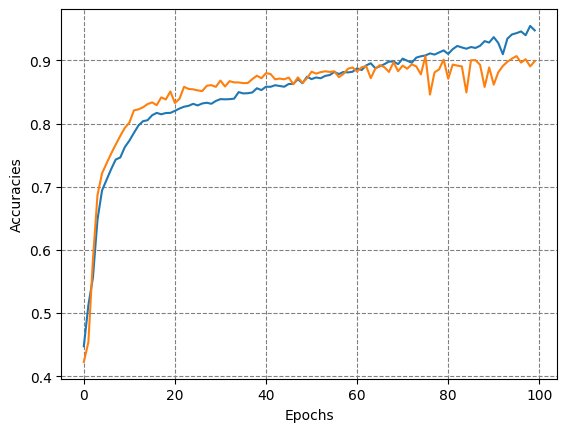

In [40]:
import seaborn as sns
plt.plot(epoch, train_result)
plt.plot(epoch, test_result)
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.grid(color='gray', linestyle='dashed')

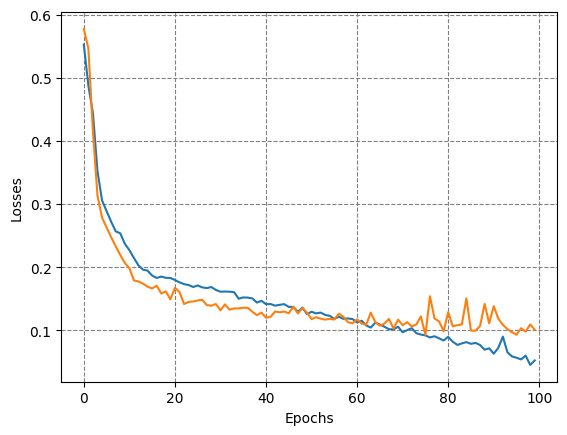

In [41]:
import seaborn as sns
plt.plot(epoch, train_loss)
plt.plot(epoch, test_loss)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.grid(color='gray', linestyle='dashed')

# Confusion Matrix

In [42]:
import torch

# Assuming your model is defined as 'model'
model = model.to('cuda')  # Move the model's weights to the GPU





In [43]:
#Code for COnfusion Matrix
nb_classes = 4

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_iterator):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[170.,   1.,   0.,   1.],
        [  0., 119.,   0.,   0.],
        [  0.,   6.,  48.,  36.],
        [  1.,   1.,  11., 168.]])


In [44]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9884, 1.0000, 0.5333, 0.9282])


<Axes: >

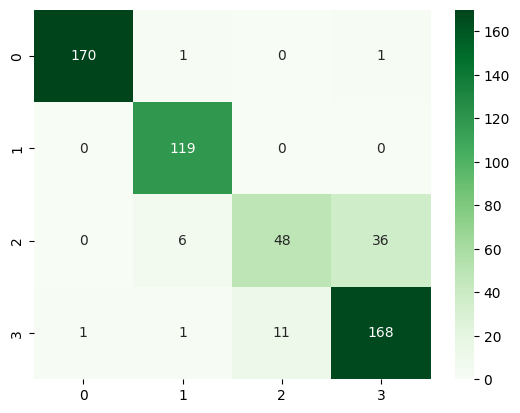

In [45]:
classes=['Penicillium Leaf curling', 'Pythium Chlorotic disease', 'Rhizoctonia seedling blight','Healthy' ]
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Greens')

# Single Image Prediction

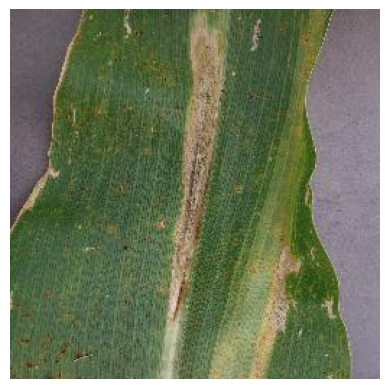

Actual class: Rhizoctonia seedling blight
Predicted class: 2


In [50]:
import cv2
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Load the model
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(2048, 4)  # Replace '4' with the number of classes in your model

# Load and transform the image
img = cv2.imread('/content/drive/MyDrive/Datasetss/Testing/Rhizoctonia seedling blight/Rhizoctonia seedling blight (100).JPG')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct visualization

# Define the transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Apply normalization if needed
])

# Apply the transformation to img
img = transform(img)

# Add batch dimension
img = img.unsqueeze(0)

# Move the image to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img = img.to(device)

# Perform inference
model = model.to(device)
model.eval()
with torch.no_grad():
    output = model(img)

# Get predicted class
_, predy = torch.max(output, 1)

# Display the image and print the predicted class
plt.imshow(img1)
plt.axis('off')
plt.show()
print('Actual class: Rhizoctonia seedling blight')
print('Predicted class:', predy.item())
